In [1]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
import scipy.io as sio
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
from vit_pytorch import ViT
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os

In [2]:
import argparse
import collections
import math
import time

import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from torchsummary import summary
import geniter
import record
import Utils
import gc

from thop import profile

In [3]:
PARAM_DATASET = 'HNS'  # UP,IN,SV, KSC
PARAM_EPOCH = 50
PARAM_ITER = 1
PATCH_SIZE = 5
PARAM_VAL = 0.905
mode='DEN-1'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cross_attn_depth=1
ssf_enc_depth=1


P_dim = 128
P_dim_head=64
P_mlp_dim = 64
P_depth = 4

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
seeds = [1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341]
dataset = PARAM_DATASET 
Dataset = dataset.upper()

In [6]:
def load_dataset(Dataset, split=0.95):
    data_path = './../data/'
    if Dataset == 'HNS':
        mat_data = sio.loadmat(data_path + '2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')
        mat_gt = sio.loadmat(data_path + 'GRSS2013.mat')
        data_hsi = mat_data['ans']
        gt_hsi = mat_gt['name']
        K = 144
        TOTAL_SIZE = 15029
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'UP':
        uPavia = sio.loadmat(data_path + 'PaviaU.mat')
        gt_uPavia = sio.loadmat(data_path + 'PaviaU_gt.mat')
        data_hsi = uPavia['paviaU']
        gt_hsi = gt_uPavia['paviaU_gt']
        K = 103
        TOTAL_SIZE = 42776
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'SV':
        SV = sio.loadmat(data_path + 'Salinas_corrected.mat')
        gt_SV = sio.loadmat(data_path + 'Salinas_gt.mat')
        data_hsi = SV['salinas_corrected']
        gt_hsi = gt_SV['salinas_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 54129
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    shapeor = data_hsi.shape
    data_hsi = data_hsi.reshape(-1, data_hsi.shape[-1])
    data_hsi = PCA(n_components=K).fit_transform(data_hsi)
    shapeor = np.array(shapeor)
    shapeor[-1] = K
    data_hsi = data_hsi.reshape(shapeor)

    return data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT

In [7]:
data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT = load_dataset(
    Dataset, PARAM_VAL)

In [8]:
image_x, image_y, BAND = data_hsi.shape

In [9]:
data = data_hsi.reshape(
    np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
data.shape

(664845, 144)

In [10]:
gt_hsi.shape

(349, 1905)

In [11]:
gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
gt.shape
CLASSES_NUM = max(gt)

In [12]:
PATCH_LENGTH = PATCH_SIZE

In [13]:
img_rows = 2 * PATCH_LENGTH + 1
img_cols = 2 * PATCH_LENGTH + 1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]
VAL_SIZE = int(TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

In [14]:
data = preprocessing.scale(data)
data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])
whole_data = data_
padded_data = np.lib.pad(
    whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH),
                 (0, 0)),
    'constant',
    constant_values=0)

In [15]:
def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [
            j for j, x in enumerate(ground_truth.ravel().tolist())
            if x == i + 1
        ]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes

In [16]:
index_iter=0
np.random.seed(seeds[index_iter])
train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
_, total_indices = sampling(1, gt)

TRAIN_SIZE = len(train_indices)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
VAL_SIZE = int(TRAIN_SIZE)

print('-----Selecting Small Pieces from the Original Cube Data-----')
x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
        TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
        total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
        INPUT_DIMENSION, 32, gt)  #batchsize in 1

-----Selecting Small Pieces from the Original Cube Data-----
Train size:  (1420, 11, 11, 144)


In [17]:
#band_patch=1
band=x_train.shape[-1]
patch=x_train.shape[-2]

In [18]:
model = ViT(
    image_size = patch,
    num_patches = band,
    num_classes = CLASSES_NUM,
    dim = P_dim,
    dim_head=P_dim_head,
    mlp_dim = P_mlp_dim,
    depth = P_depth,
    heads = 4,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = mode,
    cross_attn_depth = cross_attn_depth, 
    ssf_enc_depth = ssf_enc_depth
)

In [19]:
dummy_input = torch.randn(1,patch,patch,band)
flops, params = profile(model, (dummy_input,))
print('flops: ', flops, 'params: ', params)
print('flops: %.2f M, params: %.2f M' % (flops / 1000000.0, params / 1000000.0))

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
flops:  222240640.0 params:  1877789.0
flops: 222.24 M, params: 1.88 M


In [20]:
def train(net,
          train_iter,
          valida_iter,
          loss,
          optimizer,
          device,
          epochs,
          early_stopping=False,
          early_num=20):
    loss_list = [100]
    early_epoch = 0

    net = net.to(device)
    print("training on ", device)
    start = time.time()
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    for epoch in range(epochs):
        train_acc_sum, n = 0.0, 0
        time_epoch = time.time()
        lr_adjust = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=PARAM_EPOCH//10, gamma=0.9)
        for X, y in train_iter:

            batch_count, train_l_sum = 0, 0
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y.long())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        lr_adjust.step()
        valida_acc, valida_loss = record.evaluate_accuracy(
            valida_iter, net, loss, device)
        loss_list.append(valida_loss)

        train_loss_list.append(train_l_sum)  # / batch_count)
        train_acc_list.append(train_acc_sum / n)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

        print(
            'epoch %d, train loss %.6f, train acc %.3f, valida loss %.6f, valida acc %.3f, time %.1f sec'
            % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
               valida_loss, valida_acc, time.time() - time_epoch))

        PATH = "./net_DBA.pt"

        if early_stopping and loss_list[-2] < loss_list[-1]:
            if early_epoch == 0:
                torch.save(net.state_dict(), PATH)
            early_epoch += 1
            loss_list[-1] = loss_list[-2]
            if early_epoch == early_num:
                net.load_state_dict(torch.load(PATH))
                break
        else:
            early_epoch = 0

    print('epoch %d, loss %.4f, train acc %.3f, time %.1f sec'
          % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
             time.time() - start))

In [21]:
loss = torch.nn.CrossEntropyLoss()

In [22]:
ITER = PARAM_ITER
KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))

In [23]:
del data_hsi,data,data_
gc.collect()

631

In [24]:
for index_iter in range(ITER):
    print('iter:', index_iter)
    
    np.random.seed(seeds[index_iter])
    train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
    _, total_indices = sampling(1, gt)

    TRAIN_SIZE = len(train_indices)
    TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
    VAL_SIZE = int(TRAIN_SIZE)

    print('-----Selecting Small Pieces from the Original Cube Data-----')
    x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
            TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
            total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
            INPUT_DIMENSION, 32, gt) 

    del all_data,gt_all
    gc.collect()
    
    band=x_train.shape[-1]
    patch=x_train.shape[-2]
    
    
    x_train=torch.from_numpy(x_train).type(torch.FloatTensor) 
    y_train=torch.from_numpy(y_train).type(torch.FloatTensor) 
    Label_train=Data.TensorDataset(x_train,y_train)
    
    del x_train,y_train
    gc.collect()
    
    x_test=torch.from_numpy(x_test).type(torch.FloatTensor)
    y_test=torch.from_numpy(y_test).type(torch.FloatTensor) 
    Label_test=Data.TensorDataset(x_test,y_test)
    
    del x_test,y_test
    gc.collect()
    
    x_val=torch.from_numpy(x_val).type(torch.FloatTensor)
    y_val=torch.from_numpy(y_val).type(torch.FloatTensor)
    Label_val=Data.TensorDataset(x_val,y_val)
    
    del x_val,y_val
    gc.collect()
    

    
    
    label_train_loader=Data.DataLoader(Label_train,batch_size=32,shuffle=True)
    label_test_loader=Data.DataLoader(Label_test,batch_size=32,shuffle=False)
    label_val_loader=Data.DataLoader(Label_val,batch_size=32,shuffle=False)
    
    del Label_train,Label_test,Label_val
    gc.collect()
    model = ViT(
    image_size = patch,
    num_patches = band,
    num_classes = CLASSES_NUM,
    dim = P_dim,
    dim_head=P_dim_head,
    mlp_dim = P_mlp_dim,
    depth = P_depth,
    heads = 4,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = mode,
    cross_attn_depth = cross_attn_depth, 
    ssf_enc_depth = ssf_enc_depth
)
    model = model.cuda()
    model.train()
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.01,
        weight_decay=0)

    
    tic1 = time.time()
    train(
            model,
            label_train_loader,
            label_val_loader,
            loss,
            optimizer,
            device,
            epochs=PARAM_EPOCH)
    toc1 = time.time()
    
    
    
    pred_test = []
    tic2 = time.time()
    with torch.no_grad():
        for X, y in label_test_loader:
            X = X.to(device)
            model.eval()
            y_hat = model(X)
            pred_test.extend(np.array(model(X).cpu().argmax(axis=1)))
    toc2 = time.time()
    collections.Counter(pred_test)
    gt_test = gt[test_indices] - 1

    overall_acc = metrics.accuracy_score(pred_test, gt_test[:-VAL_SIZE])
    confusion_matrix = metrics.confusion_matrix(pred_test, gt_test[:-VAL_SIZE])
    each_acc, average_acc = record.aa_and_each_accuracy(confusion_matrix)
    kappa = metrics.cohen_kappa_score(pred_test, gt_test[:-VAL_SIZE])
    
    KAPPA.append(kappa)
    OA.append(overall_acc)
    AA.append(average_acc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc
    
    del label_train_loader,label_test_loader,label_val_loader
    gc.collect()
    
print("--------" + " Training Finished-----------")
record.record_output(
    OA, AA, KAPPA, ELEMENT_ACC, TRAINING_TIME, TESTING_TIME, flops, params,
    './report/' + 'CS2DT'+ Dataset + '_' +str(mode)+'_dep_'+str(P_depth)+'_SSF_'+str(ssf_enc_depth)+'_Cro_'+str(cross_attn_depth)+'_Patch_'+ str(img_rows) + '_' +'spl'
    + str(VALIDATION_SPLIT) +'.txt')


iter: 0
-----Selecting Small Pieces from the Original Cube Data-----
Train size:  (1420, 11, 11, 144)
training on  cuda
epoch 1, train loss 1.178180, train acc 0.428, valida loss 1.516509, valida acc 0.611, time 11.5 sec
epoch 2, train loss 0.675451, train acc 0.758, valida loss 0.508353, valida acc 0.836, time 11.2 sec
epoch 3, train loss 0.658265, train acc 0.869, valida loss 1.106482, valida acc 0.789, time 11.2 sec
epoch 4, train loss 0.896621, train acc 0.870, valida loss 0.516349, valida acc 0.840, time 8.6 sec
epoch 5, train loss 0.042012, train acc 0.911, valida loss 0.289340, valida acc 0.873, time 4.5 sec
epoch 6, train loss 0.102504, train acc 0.958, valida loss 0.042825, valida acc 0.937, time 4.5 sec
epoch 7, train loss 0.178528, train acc 0.963, valida loss 0.072069, valida acc 0.906, time 4.5 sec
epoch 8, train loss 0.359778, train acc 0.925, valida loss 0.095597, valida acc 0.877, time 4.5 sec
epoch 9, train loss 0.240933, train acc 0.929, valida loss 0.143175, valida a

In [25]:
x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
            TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
            total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
            INPUT_DIMENSION, 32, gt) 

Train size:  (1420, 11, 11, 144)


In [26]:
del whole_data,padded_data,x_train,y_train, x_val,y_val, x_test,y_test
gc.collect()

0

In [27]:
x_all=torch.from_numpy(all_data).type(torch.FloatTensor)
y_all=torch.from_numpy(gt_all).type(torch.FloatTensor)
Label_all=Data.TensorDataset(x_all,y_all)

In [28]:
del x_all,y_all
gc.collect()

0

In [29]:
label_all_loader=Data.DataLoader(Label_all,batch_size=32,shuffle=False)

------Get classification maps successful-------


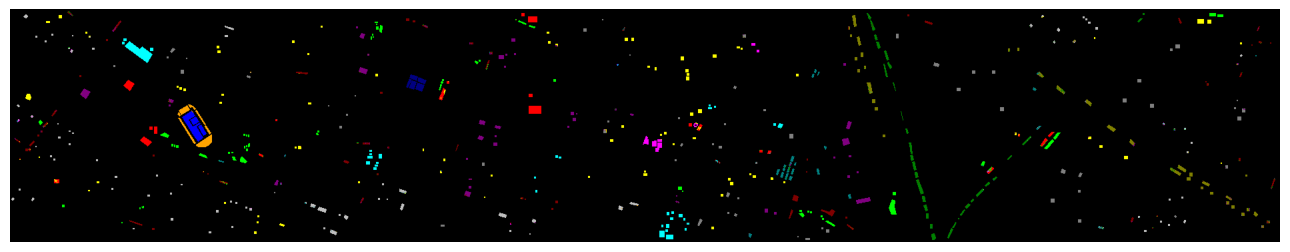

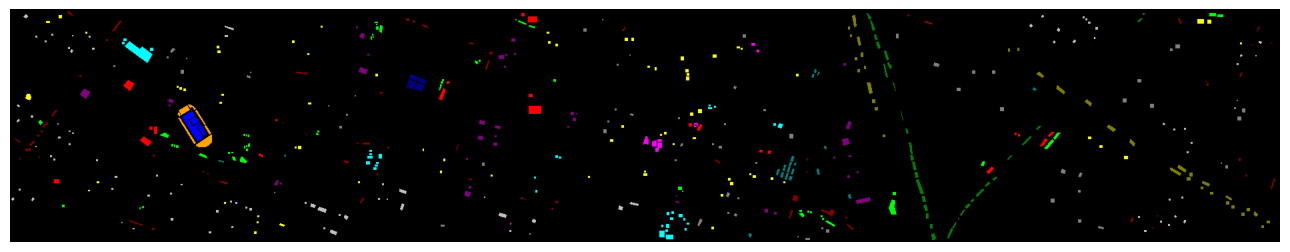

In [30]:
Utils.generate_png(
    label_all_loader, model, gt_hsi, Dataset, device, total_indices,
    './classification_maps/' + 'CS2DT'+ Dataset + '_' +str(mode)+'_dep_'+str(P_depth)+'_SSF_'+str(ssf_enc_depth)+'_Cro_'+str(cross_attn_depth)+'_Patch_'+ str(img_rows) + '_' +'spl'
    + str(VALIDATION_SPLIT))